# Programming Assignment 1
## Genre Classification using Locality Sensitive Hashing (LSH)


## README How to use this Notebook

### Introduction
This readme describes how to use the pa1.ipynb file in this directory. 

### Getting Started
To get started, make sure you have all the necessary Python imports installed. If any of the imports are missing, you can use the `pip install` command to install the required dependencies. Alternatively, you can use an IDE like PyCharm, which may assist you in resolving any dependency issues.

### Running the Notebook
To run this notebook, simply execute each cell in sequential order. Each cell contains a block of code or markdown text that serves a specific purpose. You can run the cells individually or use the "Run All" option to execute all cells at once.
For the data make sure that the two files `tracks.csv` and `features.csv` are in the same directory as this notebook!

### Important Note
Please note that the parameter optimization at the end of the notebook can be time-consuming. If you wish, you can skip the last few cells to save time. However, keep in mind that skipping these cells may affect the accuracy of the genre classification.

### Need Help?
If you encounter any issues or have any questions, please feel free to reach out to us. Your professor should have our contact information. Alternatively as a student, you can ask for assistance in the Computer Science Discord server. Make sure to post your question in the correct channel (MMD), and we will be happy to help you.



# Imports for the Notebook

In [10]:
#Imports

import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Data Loading and Preprocessing 
Loads the data from the csv, please make sure to have the two csv files tracks & featrues.csv in the same directory as this notebook !


In [11]:

# Load data
df_tracks = pd.read_csv('tracks.csv', index_col=0, header=[0, 1])
df_tracks = df_tracks[df_tracks['set']['subset'] == 'medium']
df_features = pd.read_csv('features.csv', index_col=0, header=[0, 1, 2])

# Filter by genres
df_tracks = df_tracks[df_tracks['track']['genre_top'].isin(['Hip-Hop', 'Pop', 'Folk', 'Rock', 'Experimental', 'International', 'Electronic', 'Instrumental'])]

# Split df_tracks into training, testing, and validation sets
df_tracks_train = df_tracks[df_tracks.iloc[:, 30] == 'training']
df_tracks_test = df_tracks[df_tracks.iloc[:, 30] == 'test']
df_tracks_validation = df_tracks[df_tracks.iloc[:, 30] == 'validation']

# Match features with tracks for training, testing, and validation
df_features_train = df_features[df_features.index.isin(df_tracks_train.index)]
df_features_test = df_features[df_features.index.isin(df_tracks_test.index)]
df_features_validation = df_features[df_features.index.isin(df_tracks_validation.index)]

# Extract feature values
X_train = df_features_train.values
X_test = df_features_test.values
X_validation = df_features_validation.values



# Extract genre labels
y_train = df_tracks_train['track']['genre_top']
y_test = df_tracks_test['track']['genre_top']
y_validation = df_tracks_validation['track']['genre_top']

# create smaller test subset from test
X_test_small = X_test[:25]
y_test_small = y_test[:25]

# Combine validation and training sets
df_tracks_combined = df_tracks[(df_tracks.iloc[:, 30] == 'training') | (df_tracks.iloc[:, 30] == 'validation')]
df_features_combined = df_features[df_features.index.isin(df_tracks_combined.index)]

# Extract feature values and genre labels
X_combined = df_features_combined.values
y_combined = df_tracks_combined['track']['genre_top']


### Random Projection Matrix

This generates a random matrix which is then used in order to create the hashing . For details look into the paper mentioned in the assigment. 

In [12]:
# r_i = rowsize, r_j) = columsize
def generate_random_matrix(r_i, r_j):
    """
    Generates a random matrix of size (r_i, r_j) with elements randomly chosen from the set {-1, 0, 1}.
    The probabilities of choosing -1, 0, and 1 are 1/6, 2/3, and 1/6 respectively.

    Parameters:
    r_i (int): The number of rows in the matrix.
    r_j (int): The number of columns in the matrix.

    Returns:
    numpy.ndarray: The generated random matrix.
    """
    rij = np.random.choice([-1, 0, 1], size=(r_i, r_j), p=[1/6, 2/3, 1/6])
    return np.sqrt(3) * rij

### Hashtable generator function

We use the transpose of the Random Projection Matrix to reduce the dimensionality  and determine the orientation of each track's data relative to the hyperplanes by using the dot Product of the feature matrix and the transposed Random Projection Matrix. 
Then we use the binary representations of the orientations as a bucket and put in the tracks accordingly. 
$ \begin{cases} 
0 & \text{ if } x < 0 \\
1 & \text{ else}
\end{cases}
$ 
We can do this because of $\mathbf{a} \cdot \mathbf{b} = \|\mathbf{a}\| \|\mathbf{b}\| \cos(\theta)$ positive means on one side and negative on the other.
This whole process represents one hashtable.

In [13]:
"""
The binary representations are of length l.
And the number of hashtables we creat is equal to n.
"""
def hashtable_generator(X, l=64, n=2):
    hash_tables_and_matrices = []  
    for _ in range(n):
        buckets = {}
        random_matrix = generate_random_matrix(l, X.shape[1])
        X_dot = np.dot(X, random_matrix.T)
        X_dot = X_dot > 0
        X_dot = X_dot.astype(int)

        for i in range(len(X_dot)):
            hash_str = ''.join(X_dot[i].astype(str))
            if hash_str not in buckets:
                buckets[hash_str] = []
            buckets[hash_str].append(i)
        
        hash_tables_and_matrices.append((buckets, random_matrix))
        
    
    return hash_tables_and_matrices


### Similar Songs Finder
In this step we use the computed hash_tables and the according matrices to find all similar songs of the input song. 
> A music track is defined as similar if it is in the same bucket as $t_i$ in one of the $n$ hash tables.
 
If no exact matches are found in any bucket, we proceed to calculate the Hamming distance between the bucket and other buckets and choose similar buckets and then return the songs of similar buckets in order to avoide the case that no songs are found. Furthermore we use this technique if there less than 3 songs found in order to improve the accuracy as in the next step the exact distance is calculated anyway. 


In [14]:
import itertools

def find_similar_songs(song_input, hash_tables_and_matrices):
    """
    Finds similar songs based on the input song and a list of hash tables and matrices.

    Parameters:
    - song_input: numpy array representing the input song
    - hash_tables_and_matrices: list of tuples containing hash tables and random matrices

    Returns:
    - List of indices of similar songs
    """

    similar_songs_indices = set()

    # First, try to find an exact match in any of the hash table and matrix combinations
    for buckets, random_matrix in hash_tables_and_matrices:
        song_projected = np.dot(song_input, random_matrix.T) > 0
        song_hash = ''.join(song_projected.astype(int).astype(str))

        if song_hash in buckets:
            similar_songs_indices.update(buckets[song_hash])

    # If no exact match is found in any combination, try to find the closest 10 buckets
    # bit complicated tbh but it works quit well I think for the case that sometimes there are not enough similar songs in the bucket
    if len(similar_songs_indices) < 3:
        #print("empty bucket")
        closest_bucket_names = []
        min_hamming_distances = []
        
        for buckets, random_matrix in hash_tables_and_matrices:
            song_projected = np.dot(song_input, random_matrix.T) > 0
            song_hash = ''.join(song_projected.astype(int).astype(str))

            bucket_hamming_distances = [(hamming_distance(song_hash, bucket_name), bucket_name) for bucket_name in buckets.keys()]
            bucket_hamming_distances.sort(key=lambda x: x[0])
            closest_bucket_names.extend([bucket_name for _, bucket_name in bucket_hamming_distances[:10]])
            min_hamming_distances.extend([hamming_dist for hamming_dist, _ in bucket_hamming_distances[:10]])

        closest_bucket_names = list(dict.fromkeys(closest_bucket_names))  # Remove duplicates
        min_hamming_distances = list(dict.fromkeys(min_hamming_distances))  # Remove duplicates

        for bucket_name, min_hamming_distance in zip(closest_bucket_names, min_hamming_distances):
            for buckets, _ in hash_tables_and_matrices:
                if bucket_name in buckets and buckets[bucket_name]:
                    similar_songs_indices.update(buckets[bucket_name])
                    break
    return list(similar_songs_indices)

# just wrote it quick instead of using a libary
def hamming_distance(str1, str2):
    """Calculate the Hamming distance between two binary strings"""
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

### Distance Computation of Similar Songs
This function computes the distance of all similar Songs to the input Song and returns them.

In [15]:
def compute_distances(X, song_input, similar_songs, metric="euclid", cut=10):
    """
    Compute distances between a given song input and a list of similar songs.

    Parameters:
    - X (numpy.ndarray): Array of songs.
    - song_input (numpy.ndarray): Input song to compare distances with.
    - similar_songs (list): List of indices of similar songs.
    - metric (str, optional): Distance metric to use. Default is "euclid".
    - cut (int, optional): Number of similar songs to return. Default is 10.

    Returns:
    - list: Indices of the most similar songs based on the specified metric and cut.

    Raises:
    - ValueError: If an invalid metric is specified.

    """
    filtered_songs = []
    if metric == "euclid":
        for element in similar_songs:
            distance = np.linalg.norm(X[element] - song_input)
            filtered_songs.append((element, distance))
    elif metric == "cosine":
        for element in similar_songs:
            # cosine similarity
            dot_product = np.dot(X[element], song_input)
            norm_song = np.linalg.norm(X[element])
            norm_input = np.linalg.norm(song_input)
            similarity = dot_product / (norm_song * norm_input)
            
            # From similarity to distance (cosine distance)
            distance = 1 - similarity
            filtered_songs.append((element, distance))
    else:
        raise ValueError("Invalid metric specified. Use 'euclid' or 'cosine'.")
    
    sorted_songs = sorted(filtered_songs, key=lambda x: x[1])
    if cut is not None:
        sorted_songs = sorted_songs[:cut]
    
    return [index for index, _ in sorted_songs]

### Getting the Genre by Majority vote

This method just outputs the genre that is most used by the songs that are provided.

In [16]:
def determine_genre_by_majority_vote(song_indices, Y):
    """
    Determines the genre of a song by majority vote based on a list of song indices and their corresponding genres.

    Parameters:
    - song_indices (list): A list of indices representing the songs.
    - Y (pandas Series): A pandas Series containing the genres of the songs.

    Returns:
    - str: The genre that appears most frequently in the given list of song indices.

    If no similar songs are found, the function returns 'Rock' as the default genre.
    """
    genres = []
    for index in song_indices:
        genres.append(Y.iloc[index])
    if len(genres) == 0:
        print("No similar songs found.")
        return 'Rock'
    return max(set(genres), key=genres.count)


### This is the complete Operation

This can be used to find the genre for a song which combines most steps described here before

In [17]:
def find_song_genre(song, X, Y, hashtables=None, l=64, n=2, cut=10, metric="euclid"):
    """
    Finds the genre of a given song based on its similarity to other songs in a dataset.

    Parameters:
    - song: The song for which the genre needs to be determined.
    - X: The dataset of songs.
    - Y: The corresponding genres of the songs in the dataset.
    - hashtables: Optional. The hash tables used for efficient nearest neighbor search. If not provided, new hash tables will be generated.
    - l: Optional. The number of hash tables to generate. Default is 64.
    - n: Optional. The number of hash functions per table. Default is 2.
    - cut: Optional. The number of nearest neighbors to consider. Default is 10.
    - metric: Optional. The distance metric used for computing distances. Default is "euclid".

    Returns:
    - The genre of the given song.
    """
    if hashtables is None:
        hashtables = hashtable_generator(X, l, n)
    similar_songs = find_similar_songs(song, hashtables)
    nearest_neighbours = compute_distances(X, song, similar_songs, metric, cut)
    genre = determine_genre_by_majority_vote(nearest_neighbours, Y)

    return genre
def find_song_genre(song, X,Y, hashtables = None, l=64, n=2, cut=10, metric="euclid"):
    if hashtables is None:
        hashtables = hashtable_generator(X,l, n)
    similar_songs = find_similar_songs(song, hashtables)
    nearest_neighbours = compute_distances(X,song, similar_songs, metric, cut)
    genre =  determine_genre_by_majority_vote(nearest_neighbours, Y)
    
    return genre 

### Test and Validation Score

Here we define a function to get the test accuracy. 
We create the hastables with the training data and then use the testing data to guess the genres of the testing songs and check it against the true lables. 

In [28]:
def test_accuracy(l=64, n=2, cut=10, metric="euclid"):
    """
    Calculate the test accuracy 

    Parameters:
    - l (int): The number of hash functions to be used in the hashtable generator.
    - n (int): The number of hashtables to be generated.
    - cut (int): The number of nearest neighbors to consider for genre classification.
    - metric (str): The distance metric to be used for genre classification.

    Returns:
    - accuracy (float): The test accuracy of the algorithm.
    - test_time (float): The time taken to test the algorithm in seconds.
    """
    start_time = time.time()  # Start time measurement

    hashtables = hashtable_generator(X_train, l, n)  # Assuming you have this function defined elsewhere
    correct = 0
    for index in tqdm(range(len(X_validation)), desc="Progress"):
        song = X_validation[index]
        genre = find_song_genre(song, X_train, y_train, hashtables, l, n, cut, metric)  
        if genre == y_validation.iloc[index]:
            correct += 1

    accuracy = correct / len(X_validation)
    end_time = time.time()  # End time measurement
    test_time = end_time - start_time

    print(f"Test accuracy: {accuracy}")
    print(f"Test time: {test_time} seconds")
    return accuracy, test_time

### Looking for the best hyperparameter
We define a function that takes hyperparameters and returns accuracy and runtime. 

In [19]:
def find_best_parameters_test(l_values, n_values, cut_values, metric_values):
    """
    Finds the best parameters for the test by iterating through provided values of 'l', 'n', 'cut', and 'metric'.
    Saves the parameters, accuracy, and test time for each combination in a dictionary and keeps track of the best accuracy and corresponding parameters.
    Finally, prints the best parameters, best accuracy found, the best test time, and the complete results dictionary.

    Parameters:
    - l_values (list): List of values for 'l' to iterate over.
    - n_values (list): List of values for 'n' to iterate over.
    - cut_values (list): List of values for 'cut' to iterate over.
    - metric_values (list): List of metrics to iterate over.

    Returns:
    - results (dict): A dictionary containing the results.
    """
    results = {}  # Dictionary to save the results
    best_accuracy = 0
    best_parameters = None
    best_time = None
    
    for l in l_values:
        for n in n_values:
            for cut in cut_values:
                for metric in metric_values:
                    # Test the current parameter combination
                    accuracy, test_time = test_accuracy(l, n, cut, metric)  # Assuming test_accuracy returns (accuracy, time)
                    
                    # Save the parameters, accuracy, and test time in the dictionary
                    results[(l, n, cut, metric)] = {'accuracy': accuracy, 'time': test_time}
                    
                    # Update the best parameters, accuracy, and test time if the current accuracy is the best found so far
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_parameters = (l, n, cut, metric)
                        best_time = test_time
    
    
    print("Best parameters:", best_parameters)
    print(f"Best accuracy: {best_accuracy}, Test time: {best_time} seconds")
    
    return results

## Training Hyperparameters

$l$: The number of hash tables to generate. 
$n$: The number of hash functions per table.
**cut**: The number of nearest neighbors to consider.
**metric**: The distance metric used for computing distances.

In [30]:
#We commented this out because it took us 2 hours doing so 
#results_final = find_best_parameters_test([64, 128, 156], [2, 8, 16], [6, 10, 15], ["euclid","cosine"])

Progress: 100%|██████████| 1495/1495 [00:19<00:00, 77.71it/s]


Test accuracy: 0.6167224080267558
Test time: 21.01184582710266 seconds


Progress: 100%|██████████| 1495/1495 [00:13<00:00, 107.15it/s]


Test accuracy: 0.6073578595317726
Test time: 15.38938593864441 seconds


Progress: 100%|██████████| 1495/1495 [00:17<00:00, 83.41it/s] 


Test accuracy: 0.6173913043478261
Test time: 19.618459463119507 seconds


Progress: 100%|██████████| 1495/1495 [00:24<00:00, 60.42it/s]


Test accuracy: 0.6147157190635452
Test time: 26.051724195480347 seconds


Progress: 100%|██████████| 1495/1495 [00:16<00:00, 92.26it/s] 


Test accuracy: 0.6180602006688963
Test time: 17.497107982635498 seconds


Progress: 100%|██████████| 1495/1495 [00:29<00:00, 50.95it/s]


Test accuracy: 0.611371237458194
Test time: 30.609276056289673 seconds


Progress: 100%|██████████| 1495/1495 [00:47<00:00, 31.50it/s]


Test accuracy: 0.6140468227424749
Test time: 52.408241748809814 seconds


Progress: 100%|██████████| 1495/1495 [02:25<00:00, 10.25it/s]


Test accuracy: 0.6187290969899666
Test time: 150.60785365104675 seconds


Progress: 100%|██████████| 1495/1495 [01:01<00:00, 24.28it/s]


Test accuracy: 0.6133779264214047
Test time: 66.14052939414978 seconds


Progress: 100%|██████████| 1495/1495 [01:23<00:00, 17.96it/s]


Test accuracy: 0.6220735785953178
Test time: 87.83682203292847 seconds


Progress: 100%|██████████| 1495/1495 [01:02<00:00, 24.04it/s]


Test accuracy: 0.6180602006688963
Test time: 66.75742840766907 seconds


Progress: 100%|██████████| 1495/1495 [01:19<00:00, 18.71it/s]


Test accuracy: 0.6234113712374582
Test time: 84.36797547340393 seconds


Progress: 100%|██████████| 1495/1495 [01:20<00:00, 18.67it/s]


Test accuracy: 0.6187290969899666
Test time: 89.78923773765564 seconds


Progress: 100%|██████████| 1495/1495 [02:27<00:00, 10.16it/s]


Test accuracy: 0.6187290969899666
Test time: 156.38239216804504 seconds


Progress: 100%|██████████| 1495/1495 [01:16<00:00, 19.59it/s]


Test accuracy: 0.6147157190635452
Test time: 85.4025559425354 seconds


Progress: 100%|██████████| 1495/1495 [02:38<00:00,  9.45it/s]


Test accuracy: 0.6234113712374582
Test time: 167.56652975082397 seconds


Progress: 100%|██████████| 1495/1495 [01:12<00:00, 20.63it/s]


Test accuracy: 0.6207357859531772
Test time: 81.50668478012085 seconds


Progress: 100%|██████████| 1495/1495 [02:21<00:00, 10.53it/s]


Test accuracy: 0.622742474916388
Test time: 151.72267413139343 seconds


Progress: 100%|██████████| 1495/1495 [00:06<00:00, 229.08it/s]


Test accuracy: 0.6006688963210702
Test time: 8.661805391311646 seconds


Progress: 100%|██████████| 1495/1495 [00:11<00:00, 125.57it/s]


Test accuracy: 0.6046822742474917
Test time: 14.05702543258667 seconds


Progress: 100%|██████████| 1495/1495 [00:12<00:00, 118.55it/s]


Test accuracy: 0.6066889632107023
Test time: 14.874375104904175 seconds


Progress: 100%|██████████| 1495/1495 [00:12<00:00, 123.39it/s]


Test accuracy: 0.611371237458194
Test time: 14.308246374130249 seconds


Progress: 100%|██████████| 1495/1495 [00:13<00:00, 113.98it/s]


Test accuracy: 0.6193979933110368
Test time: 15.611689329147339 seconds


Progress: 100%|██████████| 1495/1495 [00:14<00:00, 101.20it/s]


Test accuracy: 0.6153846153846154
Test time: 16.955706119537354 seconds


Progress: 100%|██████████| 1495/1495 [00:18<00:00, 80.96it/s] 


Test accuracy: 0.6026755852842809
Test time: 27.515973806381226 seconds


Progress: 100%|██████████| 1495/1495 [00:56<00:00, 26.35it/s]


Test accuracy: 0.611371237458194
Test time: 65.71298909187317 seconds


Progress: 100%|██████████| 1495/1495 [00:21<00:00, 70.80it/s] 


Test accuracy: 0.6127090301003344
Test time: 29.665623664855957 seconds


Progress: 100%|██████████| 1495/1495 [00:24<00:00, 60.52it/s]


Test accuracy: 0.6260869565217392
Test time: 33.18644881248474 seconds


Progress: 100%|██████████| 1495/1495 [00:27<00:00, 53.70it/s]


Test accuracy: 0.6120401337792643
Test time: 36.14232158660889 seconds


Progress: 100%|██████████| 1495/1495 [00:30<00:00, 49.28it/s]


Test accuracy: 0.6301003344481605
Test time: 38.57944083213806 seconds


Progress: 100%|██████████| 1495/1495 [00:43<00:00, 34.08it/s]


Test accuracy: 0.6153846153846154
Test time: 61.265583992004395 seconds


Progress: 100%|██████████| 1495/1495 [00:45<00:00, 32.58it/s]


Test accuracy: 0.6120401337792643
Test time: 63.922252893447876 seconds


Progress: 100%|██████████| 1495/1495 [00:25<00:00, 57.97it/s]


Test accuracy: 0.6086956521739131
Test time: 43.6849205493927 seconds


Progress: 100%|██████████| 1495/1495 [00:45<00:00, 32.81it/s]


Test accuracy: 0.6260869565217392
Test time: 63.026726484298706 seconds


Progress: 100%|██████████| 1495/1495 [00:26<00:00, 56.72it/s]


Test accuracy: 0.6267558528428093
Test time: 42.956854820251465 seconds


Progress: 100%|██████████| 1495/1495 [00:52<00:00, 28.25it/s]


Test accuracy: 0.6207357859531772
Test time: 69.72877812385559 seconds


Progress: 100%|██████████| 1495/1495 [00:32<00:00, 45.42it/s]


Test accuracy: 0.585953177257525
Test time: 35.55332922935486 seconds


Progress: 100%|██████████| 1495/1495 [00:44<00:00, 33.46it/s]


Test accuracy: 0.6080267558528428
Test time: 47.58337998390198 seconds


Progress: 100%|██████████| 1495/1495 [00:55<00:00, 27.18it/s]


Test accuracy: 0.5886287625418061
Test time: 57.62199878692627 seconds


Progress: 100%|██████████| 1495/1495 [00:59<00:00, 25.31it/s]


Test accuracy: 0.5906354515050167
Test time: 61.5945782661438 seconds


Progress: 100%|██████████| 1495/1495 [00:16<00:00, 89.51it/s] 


Test accuracy: 0.6053511705685619
Test time: 19.20572805404663 seconds


Progress: 100%|██████████| 1495/1495 [00:25<00:00, 58.35it/s]


Test accuracy: 0.611371237458194
Test time: 28.15684175491333 seconds


Progress: 100%|██████████| 1495/1495 [00:38<00:00, 38.99it/s]


Test accuracy: 0.6167224080267558
Test time: 48.524717569351196 seconds


Progress: 100%|██████████| 1495/1495 [00:27<00:00, 54.24it/s] 


Test accuracy: 0.6187290969899666
Test time: 38.52359390258789 seconds


Progress: 100%|██████████| 1495/1495 [00:32<00:00, 45.64it/s] 


Test accuracy: 0.6207357859531772
Test time: 42.98098874092102 seconds


Progress: 100%|██████████| 1495/1495 [00:32<00:00, 45.63it/s]


Test accuracy: 0.640133779264214
Test time: 42.8890221118927 seconds


Progress: 100%|██████████| 1495/1495 [00:21<00:00, 70.12it/s] 


Test accuracy: 0.6160535117056856
Test time: 31.263472080230713 seconds


Progress: 100%|██████████| 1495/1495 [00:35<00:00, 42.14it/s] 


Test accuracy: 0.6234113712374582
Test time: 46.202311277389526 seconds


Progress: 100%|██████████| 1495/1495 [00:38<00:00, 38.57it/s]


Test accuracy: 0.6153846153846154
Test time: 59.91615056991577 seconds


Progress: 100%|██████████| 1495/1495 [00:48<00:00, 30.98it/s]


Test accuracy: 0.6234113712374582
Test time: 68.3471736907959 seconds


Progress: 100%|██████████| 1495/1495 [00:31<00:00, 47.67it/s]


Test accuracy: 0.6180602006688963
Test time: 51.40841054916382 seconds


Progress: 100%|██████████| 1495/1495 [00:40<00:00, 36.54it/s]


Test accuracy: 0.6280936454849498
Test time: 61.72586488723755 seconds


Progress: 100%|██████████| 1495/1495 [00:32<00:00, 46.22it/s] 


Test accuracy: 0.6260869565217392
Test time: 52.34318208694458 seconds


Progress: 100%|██████████| 1495/1495 [00:35<00:00, 42.03it/s]

Test accuracy: 0.6173913043478261
Test time: 55.557640075683594 seconds
Best parameters: (156, 8, 10, 'cosine')
Best accuracy: 0.640133779264214, Test time: 42.8890221118927 seconds


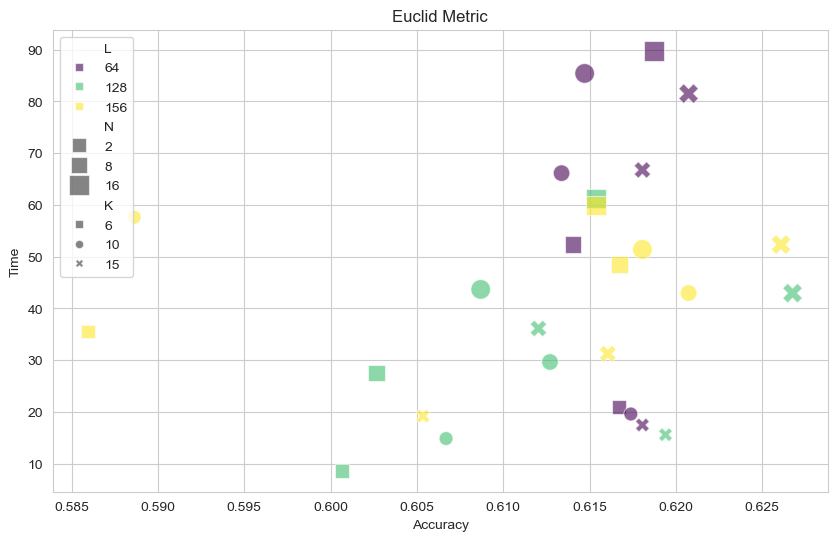

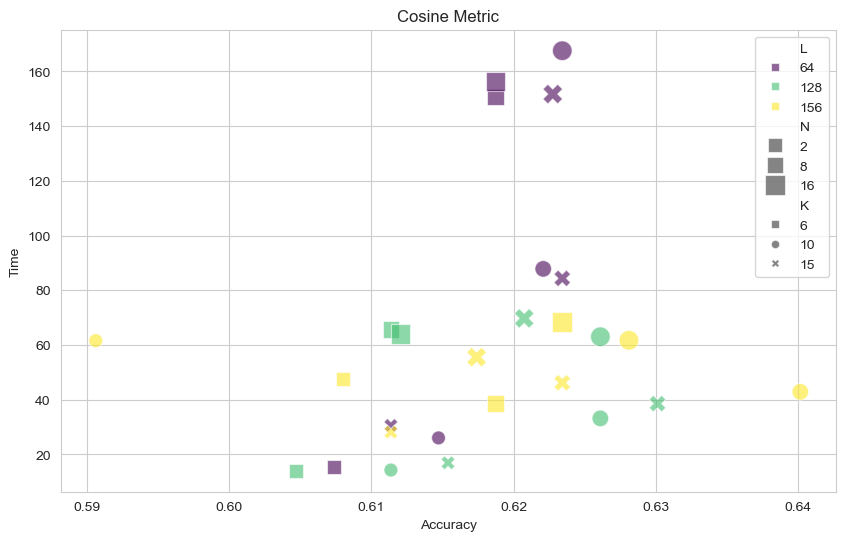

In [48]:
# Preprocessing data to fit the visualization requirements
data_euclid_final = {'Accuracy': [], 'Time': [], 'L': [], 'N': [], 'K': []}
data_cosine_final = {'Accuracy': [], 'Time': [], 'L': [], 'N': [], 'K': []}

for (l, n, k, m), values in results_final.items():
    if m == 'euclid':
        data_euclid_final['Accuracy'].append(values['accuracy'])
        data_euclid_final['Time'].append(values['time'])
        data_euclid_final['L'].append(l)
        data_euclid_final['N'].append(n)
        data_euclid_final['K'].append(k)
    elif m == 'cosine':
        data_cosine_final['Accuracy'].append(values['accuracy'])
        data_cosine_final['Time'].append(values['time'])
        data_cosine_final['L'].append(l)
        data_cosine_final['N'].append(n)
        data_cosine_final['K'].append(k)

df_euclid_final = pd.DataFrame(data_euclid_final)
df_cosine_final = pd.DataFrame(data_cosine_final)

# Custom marker function
def custom_marker(k):
    if k == 6:
        return 's'  # square
    elif k == 10:
        return 'o'  # circle
    else:
        return 'X'  # cross

# Plotting for Euclid
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_euclid_final, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={6: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Euclid Metric')
plt.grid(True)
plt.show()

plt.show()
# Plotting for Cosine
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cosine_final, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={6: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Cosine Metric')
plt.grid(True)
plt.show() 

Below we safed our results and plotted them for better comparison.

## Final Test on Validation data
Here we combined training and test data, trained our algorithm and tested on the validation data

In [22]:
def test_accuracy_final(l=128, n=16, cut=15, metric="euclid"):
    """
    Calculate the test accuracy with the combined set with validation values

    Parameters:
    - l (int): The number of hash functions to be used in the hashtable generator.
    - n (int): The number of hashtables to be generated.
    - cut (int): The number of nearest neighbors to consider for genre classification.
    - metric (str): The distance metric to be used for genre classification.

    Returns:
    - accuracy (float): The test accuracy of the algorithm.
    - test_time (float): The time taken to test the algorithm in seconds.
    """
    start_time = time.time()  # Start time measurement
    hashtables = hashtable_generator(X_combined, l, n)
    correct = 0
    for index in tqdm(range(len(X_test)), desc="Progress"):
        song = X_test[index]
        genre = find_song_genre(song, X_combined, y_combined, hashtables, l, n, cut, metric)  # Assuming you have this function defined elsewhere
        if genre == y_test.iloc[index]:

            correct += 1


    accuracy = correct / len(X_test)
    end_time = time.time()  # End time measurement
    test_time = end_time - start_time

    print(f"Test accuracy: {accuracy}")
    print(f"Test time: {test_time} seconds")
    return accuracy, test_time

In [39]:
final = test_accuracy_final(128, 8, 10, 'cosine')

Progress: 100%|██████████| 1535/1535 [00:30<00:00, 50.49it/s] 

Test accuracy: 0.6234527687296417
Test time: 43.29428791999817 seconds


In [47]:
final_2 = test_accuracy_final(128, 2, 10, 'cosine')

Progress: 100%|██████████| 1535/1535 [00:12<00:00, 127.69it/s]

Test accuracy: 0.6208469055374592
Test time: 14.720624208450317 seconds


## Briefly discuss your implementation of LSH and of the approximate nearest neighbour algorithm.
The implementation of Locality-Sensitive Hashing (LSH) is close to what we discussed in the lecture. The "hashtable_generator" function employs a technique known as dimensionality reduction through hashing, leveraging hyperplanes. As stated before: We use the transpose of the Random Projection Matrix to reduce the dimensionality  and determine the orientation of each track's data relative to the hyperplanes by using the dot Product of the feature matrix and the transposed Random Projection Matrix. 
Then we use the binary representations of the orientations as a bucket and put in the tracks accordingly. 
$ \begin{cases} 
0 & \text{ if } x < 0 \\
1 & \text{ else}
\end{cases}
$ 
We can do this because of $\mathbf{a} \cdot \mathbf{b} = \|\mathbf{a}\| \|\mathbf{b}\| \cos(\theta)$ positive means on one side and negative on the other.
This whole process represents one hashtable. To ascertain the precise neighbors, the algorithm calculates the exact distance between elements within a bucket, returning only those elements that best match the criteria defined by the 'cut' parameter. For situations where an insufficient number of elements are found, further guidance is provided in the dedicated section addressing this scenario.


## Detail how you trained your algorithm and how you performed the hyperparameter optimization. Report tested parameter and the results for these parameters.
Initially, we made the mistake of mixing up the test and validation data, and trained the model on the test data. During this process, we observed that using a hash length (l) of 256 resulted in very poor performance, as can be seen in the appended charts.

For the proper training procedure, based on the initial findings, we decided to cap the hash length (l) at 156, as we knew that further increasing the hash length would not significantly improve the results, but would only increase the computational time.

The "wrong" training sessions, where we mixed up the test and validation data, can be found in the appendix. This can be seen as a test of the estimated running times and the impact of using the wrong data for training.

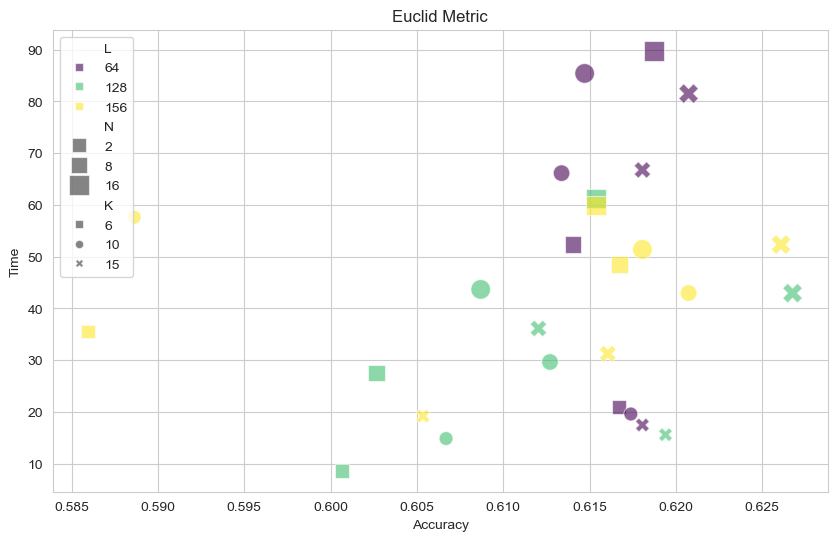

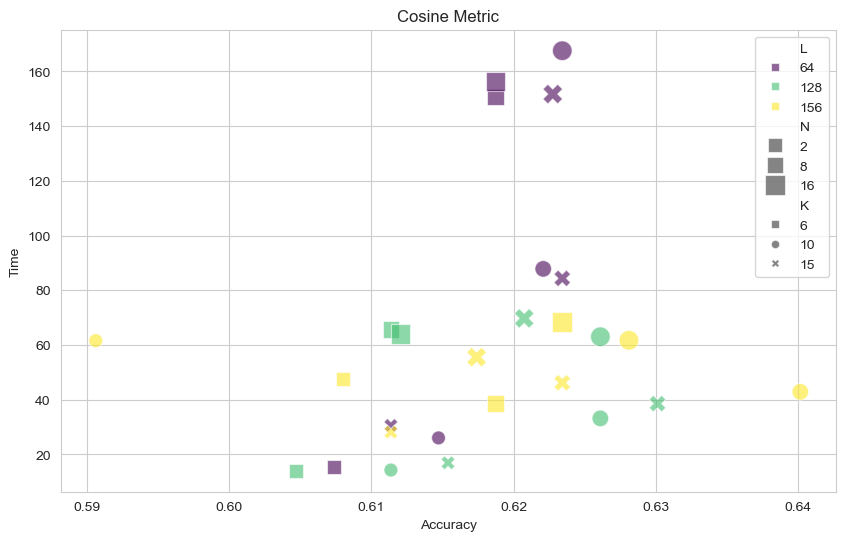

In [41]:
# Plotting for Euclid
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_euclid_final, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={6: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Euclid Metric')
plt.grid(True)
plt.show()

plt.show()
# Plotting for Cosine
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cosine_final, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={6: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Cosine Metric')
plt.grid(True)
plt.show() 

## Detail why you settled on a specific choice of l (hash length), n (number of hash tables), k (number of nearest neighbours for the prediction) and similarity measure m.

We took (156, 8, 10, 'cosine') which are the parameters with the best accuracy: 0.640133779264214 but the execution time was 42.8890221118927 seconds.
But also considered (128, 2, 10, 'cosine') as the accuracy: 0.611371237458194 is not that much worse but the execution time: 14.308246374130249 is way better.

## Report the classification accuracy of your algorithm on the test set
The final accuracy for the test set we achieved was 62.35 %.
#### "Faster version"
The final accuracy for the faster test set we achieved was 62.08%.
*both times are for the version which uses the validation set*

## Comment on why the chosen random projection method could be beneficial to drawing from a Gaussian distribution?
**Sparsity:** Achlioptas method generates a sparse matrix R and reduces computation.<br>
**Moment Preservation**: Expected value 0 and variance 1 are matching a standard Gaussian distribution.<br>
**Theoretical Guarantees:** Satisfies Johnson-Lindenstrauss lemma, preserving Distances.(Theoretical guarantee: Distances distorted by only $(1 \pm \epsilon)$.)<br>
**Computational Efficiency:** Discrete distribution simplifies random number generation and matrix operations.<br>
**Numerical Stability:** Avoids issues with small values in Gaussian random projection.<br> 


## Comment on how the runtime of your approximate nearest neighbor algorithm in comparison to that of an exact nearest neighbor search. (You can estimate runtime forthe latter case.) If your implementation is slower than the exact search, speculate about possible reasons; comment on how these aspects might change when working with larger datasets.
The runtime is better as I see it. As a exact NNS would look and compare all elements with a runtime of O(n) at least as you need to look at all the elements, however the operation that is preformaed with each of the elements is very expensive as the calculation of the exact metric can be really time extensive. 
Our solution uses hashing and then only does the exact NNS for the elements which are in the same buckets, which is most of the times only a fraction of the total tracks. Therefore the runtime is much better and it is much better scalable for large datasets as the one we use here or even bigger ones. I think the time for running our algorithm is also pretty quick and i guess the exact search would take at least 5x longer (however would most likly have a equal or better solution), however I think the tradeoff is not to large and worth it. 
Furthermore the runtime improvement is even more relevant when looking at the nearest neighbor of mulitple items, as the hashing tables from the training sets can just be reused. This lead to a even bigger improvement in runtime I would think.


## Report how you treat music tracks for which there are less than k other similar tracks.
So if there are not enough close songs found in the bucket we have a mechanism in order to ensure that some meaningful songs are found. 
The k is not to relevant here as we just cut of the similiar tracks list and provide the best k tracks. However in the case where there is only 0-2 similar tracks found we search other similar buckets in order to ensure that there are enough options for the distance calculation. This distance calculation then uses the most usefull ones, however if none or too few tracks are found the algorithm will not output the best result. Therefore we decided to implement this mechanism in order to ensure that more related tracks are found. We think that this is imporant as too few songs can make the prediction more random than it should be. This is also not really affected by the choosen k as we do not consider it usefull to use a k smaller than about 5, and we wanted to focus on the most common case here in order to have good solution with every k when there are less than 3 songs found.
Then in the case where there are less than k tracks only fewer are povided from the compute_distances function, then the majority vote function which looks through all songs and uses the genre that is used more often only uses fewer songs, if there are not more aviable. We think this solution is the most easiest and also the best working solution. 
I also want to shortly describe how the case works when not enough songs are found in a bucket. The solution we have is to look into very similar buckets with a similar name and get the songs from them and add them. In the next step where the exact distance is calculated between songs bad songs get thrown away anyway, however the function then has a better pool to choose songs from and as they are still similar we hope that an ideal solution / correct solution is found. 

## How much time did you spend on the assignment (including the writing of the report; please provide an average for all of your team members)? This will not be used for grading.
About 30 hours per person 
so 60 in total for both us 
Peer review not included

## Who did what? This will not be used for grading. This part is meant for you as a group to reflect on whether you shared the workload fairly and make adjustments for the next assignment if you observe imbalances.
Nenad did the hashtable generator in detail and looked into the theoretical part. 
While Alex did all of the validation and test scores. 
The rest was done pretty much together in equal parts. Through the entire development process of the notebook we often meet in order to improve the code together and also we both wrote together in most parts of the codde, also this report was written by both of us combined in collobaration.


## Appendix

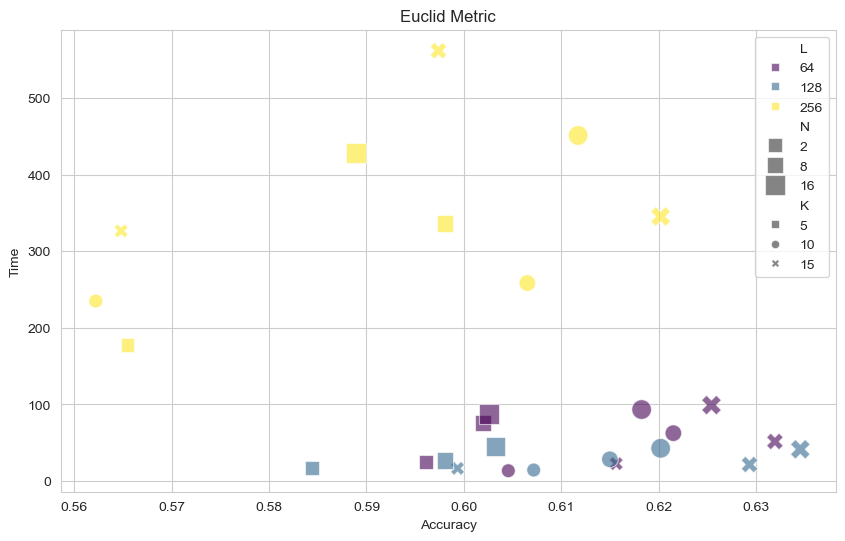

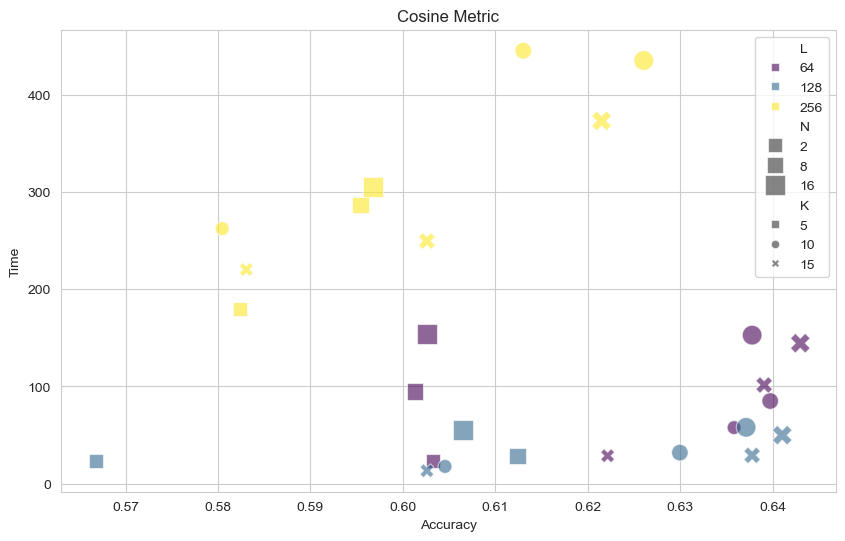

In [25]:
results = {(64, 2, 5, 'euclid'): {'accuracy': 0.5960912052117264, 'time': 24.61885380744934}, (64, 2, 5, 'cosine'): {'accuracy': 0.603257328990228, 'time': 22.938100814819336}, (64, 2, 10, 'euclid'): {'accuracy': 0.6045602605863192, 'time': 13.467969417572021}, (64, 2, 10, 'cosine'): {'accuracy': 0.6358306188925081, 'time': 57.64990282058716}, (64, 2, 15, 'euclid'): {'accuracy': 0.6156351791530945, 'time': 22.726911306381226}, (64, 2, 15, 'cosine'): {'accuracy': 0.6221498371335505, 'time': 28.7292582988739}, (64, 8, 5, 'euclid'): {'accuracy': 0.6019543973941368, 'time': 75.80211687088013}, (64, 8, 5, 'cosine'): {'accuracy': 0.6013029315960912, 'time': 94.78130793571472}, (64, 8, 10, 'euclid'): {'accuracy': 0.6214983713355049, 'time': 62.507568359375}, (64, 8, 10, 'cosine'): {'accuracy': 0.6397394136807818, 'time': 84.98335456848145}, (64, 8, 15, 'euclid'): {'accuracy': 0.6319218241042345, 'time': 51.65255784988403}, (64, 8, 15, 'cosine'): {'accuracy': 0.6390879478827362, 'time': 101.42146253585815}, (64, 16, 5, 'euclid'): {'accuracy': 0.6026058631921825, 'time': 87.87476873397827}, (64, 16, 5, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 153.76025557518005}, (64, 16, 10, 'euclid'): {'accuracy': 0.6182410423452769, 'time': 93.36437702178955}, (64, 16, 10, 'cosine'): {'accuracy': 0.637785016286645, 'time': 152.69060444831848}, (64, 16, 15, 'euclid'): {'accuracy': 0.6254071661237784, 'time': 99.14065146446228}, (64, 16, 15, 'cosine'): {'accuracy': 0.6429967426710098, 'time': 144.37975645065308}, (128, 2, 5, 'euclid'): {'accuracy': 0.5843648208469056, 'time': 16.8671395778656}, (128, 2, 5, 'cosine'): {'accuracy': 0.5667752442996743, 'time': 23.088200569152832}, (128, 2, 10, 'euclid'): {'accuracy': 0.6071661237785017, 'time': 14.384968280792236}, (128, 2, 10, 'cosine'): {'accuracy': 0.6045602605863192, 'time': 17.734903812408447}, (128, 2, 15, 'euclid'): {'accuracy': 0.5993485342019544, 'time': 16.556803941726685}, (128, 2, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 13.323764324188232}, (128, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 27.06729817390442}, (128, 8, 5, 'cosine'): {'accuracy': 0.6123778501628665, 'time': 28.310436487197876}, (128, 8, 10, 'euclid'): {'accuracy': 0.6149837133550489, 'time': 28.34497857093811}, (128, 8, 10, 'cosine'): {'accuracy': 0.6299674267100978, 'time': 31.942339658737183}, (128, 8, 15, 'euclid'): {'accuracy': 0.6293159609120521, 'time': 21.570100784301758}, (128, 8, 15, 'cosine'): {'accuracy': 0.637785016286645, 'time': 29.112306594848633}, (128, 16, 5, 'euclid'): {'accuracy': 0.603257328990228, 'time': 45.2100670337677}, (128, 16, 5, 'cosine'): {'accuracy': 0.606514657980456, 'time': 55.45202159881592}, (128, 16, 10, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 42.76470232009888}, (128, 16, 10, 'cosine'): {'accuracy': 0.6371335504885993, 'time': 57.937888622283936}, (128, 16, 15, 'euclid'): {'accuracy': 0.634527687296417, 'time': 41.43756341934204}, (128, 16, 15, 'cosine'): {'accuracy': 0.641042345276873, 'time': 49.876665115356445}, (256, 2, 5, 'euclid'): {'accuracy': 0.5654723127035831, 'time': 177.14855098724365}, (256, 2, 5, 'cosine'): {'accuracy': 0.5824104234527687, 'time': 179.3382260799408}, (256, 2, 10, 'euclid'): {'accuracy': 0.5622149837133551, 'time': 235.0748996734619}, (256, 2, 10, 'cosine'): {'accuracy': 0.5804560260586319, 'time': 262.19562244415283}, (256, 2, 15, 'euclid'): {'accuracy': 0.5648208469055375, 'time': 326.68050622940063}, (256, 2, 15, 'cosine'): {'accuracy': 0.5830618892508144, 'time': 220.1879427433014}, (256, 8, 5, 'euclid'): {'accuracy': 0.5980456026058631, 'time': 336.16090202331543}, (256, 8, 5, 'cosine'): {'accuracy': 0.5954397394136808, 'time': 286.43207907676697}, (256, 8, 10, 'euclid'): {'accuracy': 0.606514657980456, 'time': 258.5306091308594}, (256, 8, 10, 'cosine'): {'accuracy': 0.613029315960912, 'time': 445.07422518730164}, (256, 8, 15, 'euclid'): {'accuracy': 0.5973941368078176, 'time': 561.9977328777313}, (256, 8, 15, 'cosine'): {'accuracy': 0.6026058631921825, 'time': 249.47272324562073}, (256, 16, 5, 'euclid'): {'accuracy': 0.5889250814332248, 'time': 428.03207778930664}, (256, 16, 5, 'cosine'): {'accuracy': 0.596742671009772, 'time': 304.70144963264465}, (256, 16, 10, 'euclid'): {'accuracy': 0.6117263843648209, 'time': 451.31062722206116}, (256, 16, 10, 'cosine'): {'accuracy': 0.6260586319218241, 'time': 435.0277695655823}, (256, 16, 15, 'euclid'): {'accuracy': 0.6201954397394137, 'time': 345.5001907348633}, (256, 16, 15, 'cosine'): {'accuracy': 0.6214983713355049, 'time': 372.90727162361145}}
# results from above old version of the code

# Preprocessing data to fit the visualization requirements
data_euclid = {'Accuracy': [], 'Time': [], 'L': [], 'N': [], 'K': []}
data_cosine = {'Accuracy': [], 'Time': [], 'L': [], 'N': [], 'K': []}

for (l, n, k, m), values in results.items():
    if m == 'euclid':
        data_euclid['Accuracy'].append(values['accuracy'])
        data_euclid['Time'].append(values['time'])
        data_euclid['L'].append(l)
        data_euclid['N'].append(n)
        data_euclid['K'].append(k)
    elif m == 'cosine':
        data_cosine['Accuracy'].append(values['accuracy'])
        data_cosine['Time'].append(values['time'])
        data_cosine['L'].append(l)
        data_cosine['N'].append(n)
        data_cosine['K'].append(k)

df_euclid = pd.DataFrame(data_euclid)
df_cosine = pd.DataFrame(data_cosine)

# Custom marker function
def custom_marker(k):
    if k == 5:
        return 's'  # square
    elif k == 10:
        return 'o'  # circle
    else:
        return 'X'  # cross

# Plotting for Euclid
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_euclid, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={5: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Euclid Metric')
plt.grid(True)
plt.show()

plt.show()
# Plotting for Cosine
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cosine, x='Accuracy', y='Time', style='K', hue='L', size='N',
                palette='viridis', markers={5: 's', 10: 'o', 15: 'X'}, sizes=(100, 200),
                alpha=0.6).set_title('Cosine Metric')
plt.grid(True)
plt.show() 